In [1]:
import pandas as pd
import numpy as np
import altair as alt
alt.renderers.enable('notebook') # https://altair-viz.github.io/user_guide/renderers.html
alt.data_transformers.enable('json') # https://altair-viz.github.io/user_guide/faq.html

%load_ext watermark
%watermark -iv

pandas      0.22.0
numpy       1.13.3
altair      2.1.0



# Stocks

In [2]:
# multi series line chart: https://altair-viz.github.io/gallery/multi_series_line.html
# multi-line tooltip: https://altair-viz.github.io/gallery/multiline_tooltip.html

import altair as alt
from vega_datasets import data

stocks = data.stocks()

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['date'], empty='none')

# The basic line
line = alt.Chart().mark_line(interpolate='basis').encode(
    alt.X('date:T', axis=alt.Axis(title='')),
    alt.Y('price:Q', axis=alt.Axis(title='',format='$f')),
    color='symbol:N'
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart().mark_point().encode(
    x='date:T',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'price:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='gray').encode(
    x='date:T',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
stockChart = alt.layer(line, selectors, points, rules, text,
          data=stocks, width=600, height=300,title='Stock History')
stockChart.save('stocks.html')

# Airports

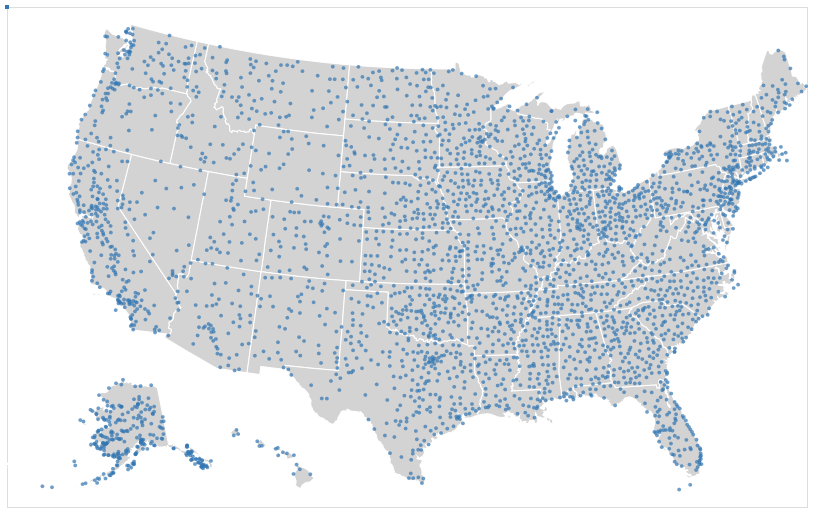

In [3]:
import altair as alt
from vega_datasets import data

states = alt.topo_feature(data.us_10m.url, feature='states')
airports = data.airports.url

# US states background
background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white',
).properties(
    width=800,
    height=500
).project('albersUsa')

# airport positions on background
points = alt.Chart(airports).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.value(15),
    color=alt.value('#3377B3'),
    tooltip=['iata:N','name:N','city:N','state:N','latitude:Q','longitude:Q'],
)

chart = (background + points)
chart.save('airports.html')
chart

# Birdstrikes

In [4]:
# This example borrows heavily from the Seattle Weather Interactive example:
# https://altair-viz.github.io/gallery/seattle_weather_interactive.html

import altair as alt 
from vega_datasets import data

# scale = alt.Scale(domain=['European starling', 'Rock pigeon', 'Mourning dove'
#                           , 'Canada goose', 'Red-tailed hawk'],
#                   range=['#e7ba52', '#a7a7a7', '#aec7e8', '#1f77b4', '#9467bd'])
# color = alt.Color('Wildlife__Species:N', scale=scale)

color = alt.Color('Wildlife__Species:N')

# We create two selections:
# - a brush that is active on the top panel
# - a multi-click that is active on the bottom panel
brush = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['color'])

# Top panel is scatter plot of temperature vs time
points = alt.Chart().mark_circle().encode(
    alt.X('Flight_Date:T', axis=alt.Axis(title='Date')),
    alt.Y('Speed_IAS_in_knots:Q',
        axis=alt.Axis(title='Indicated Airspeed (kts)'),
    ),
    color=alt.condition(brush, color, alt.value('lightgray')),
).properties(
    width=600,
    height=300
).add_selection(
    brush
).transform_filter(
    click
)

# Bottom panel is a bar chart of species
bars = alt.Chart().mark_bar().encode(
    alt.Y('count()', scale=alt.Scale(type='log')),
    alt.X('Wildlife__Species:N', sort=alt.SortField(field='sort_order', op='count', order='descending')),
    color=alt.condition(click, color, alt.value('lightgray')),
).transform_filter(
    brush
).properties(
    width=600,
).add_selection(
    click
)

alt.vconcat(points, bars,
    data=data.birdstrikes.url,
    title="Aircraft Birdstrikes: 1990-2003"
).save('birdstrikes.html')

# Clickable legend

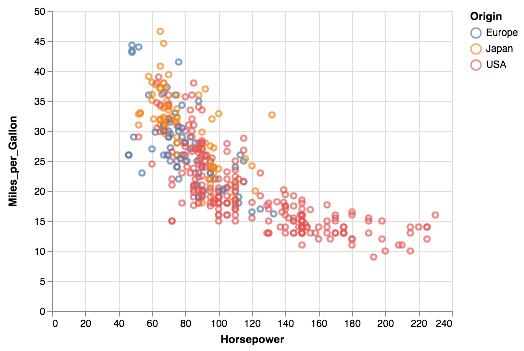

In [70]:
import altair as alt
from vega_datasets import data

cars = data.cars.url

alt.Chart(cars).mark_point().encode(
    x='Horsepower:Q',
    y='Miles_per_Gallon:Q',
    color='Origin:N'
)

In [66]:
import altair as alt
from vega_datasets import data

cars = data.cars.url

# define selection
click = alt.selection_multi(encodings=['color'])

# scatter plots of points
scatter = alt.Chart(cars).mark_circle().encode(
    x='Horsepower:Q',
    y='Miles_per_Gallon:Q',
    size=alt.Size('Cylinders:O',
        scale=alt.Scale(range=(20,100))
    ),
    color=alt.Color('Origin:N', legend=None),
    tooltip=['Name:N','Horsepower:Q','Miles_per_Gallon:Q',
             'Cylinders:O','Origin:N'],
).transform_filter(
    click
).interactive()

# legend
legend = alt.Chart(cars).mark_rect().encode(
    y=alt.Y('Origin:N', axis=alt.Axis(title='Select Origin')),
    color=alt.condition(click, 'Origin:N', 
                        alt.value('lightgray'), legend=None),
    size=alt.value(250)
).properties(
    selection=click
)

chart = (scatter | legend)
chart.save('cars-clickable-legend.html')

# Jobs

In [6]:
import altair as alt 
from vega_datasets import data

jobs = data.jobs.url

points = alt.Chart(jobs).mark_circle().encode(
    alt.X('year:T', axis=alt.Axis(title='Date')),
    alt.Y('job:N',
        axis=alt.Axis(title='Sex'),
    ),
    color='sex:N',
    size='count:Q'
).properties(
    width=600,
    height=3100
)

points.save('jobs.html')

# Flights

In [7]:
# example: http://vega.github.io/vega-tutorials/airports/


import altair as alt
from vega_datasets import data

states = alt.topo_feature(data.us_10m.url, feature='states')
airports = pd.read_csv('https://raw.githubusercontent.com/vega/vega-datasets/gh-pages/data/airports.csv')
airports['origin'] = airports['iata']
flights = pd.read_csv('https://raw.githubusercontent.com/vega/vega-datasets/gh-pages/data/flights-airport.csv')
flights = pd.merge(flights,airports[['origin','latitude','longitude']],how='left',on='origin')
# flights = flights.groupby(['origin','latitude','longitude'])['count'].sum()


# US states background
background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white',
).properties(
    width=800,
    height=500
).project('albersUsa')

# airport positions on background
points = alt.Chart(airports).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
#     size='count:Q',
    color=alt.value('#3377B3'),
#     tooltip=['iata:N','origin:N','latitude:Q','longitude:Q'],
)

chart = (background + points)
chart.save('flights.html')
chart

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>